# Modeling Crop Yield
## Python modules

In [1]:
import warnings
import time
import os

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters
#### Choose a satellite.

For a description of the Landsat 8 mission, see the US Geological metadata [here.]()

For a description of the Sentinel 2 mission, see the US Geological metadata [here.]()

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"

#### Choose band combination.

For a description of **Landsat** bands, see the [US Geological Survey documentation here.](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)

For a description of **Sentinel bands**, see the [US Geological Survey documentation here.](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2#:~:text=4%20bands%20at%2010%20meter,%2Dinfrared%20(842%20nm)

According to our results, bands **(insert band selection here)** result in the best model performance for Landsat, and **(insert band selection here)** result in the best model performance for Sentinel for the task of predicting maize yields in Zambia.

In [3]:
#bands = "2-3-4"
bands = "2-3-4-8"
# bands = "1-2-3-4-5-6-7"
# bands = "2-3-4-5-6-7-8-11-12"

#### Choose the number of points that were featurized.

Each value in the following chunk represents the amount of thousands of points that were featurized in each respective feature file. These points represent a uniform subset of the spatial grid of Zambia. Points are spaced at uniform intervals for each selection, measured in kilometers in the longitudinal direction for each set of features. The kilometer distance interval differs for each selection below; 42,000 points results in the smallest uniform distance between points, and 4,000 points results in the greatest uniform distance between points. Selecting a greater quantity of points results in a denser spatial sample, which increases computational cost and time, but increases the spatial resolution of the model. Regardless of the quantity of points selected, each point is buffered by the same distance, resulting in a 1km^2 cell around each point.

These specific options point quantities is a result of uniformly increasing the distance between points in units of kilometers prior to matching satellite images to each point. These options represent the number of points that fall within the borders of Zambia, and the numbers have been rounded to the nearest thousandth for consistency in naming files. See the [CropMOSAIKS Featurization repository](https://github.com/cropmosaiks/Featurization) for more information regarding how these distances we calculated. 

In [4]:
points = 15
# points = 20

#### Choose to keep only areas with crops (`True`) or to keep all points (`False`)

Selecting `True` applies a "cropland mask" to the spatial grid of Zambia. This retains only the regions of the country in which maize is  grown, according to the **(insert source here)**. As a result, the spatial extent of the features that are fed into the model are highly subset for the specific task at hand: modeling maize yields. According to our results, selecting `True` **(insert increases or decreases here)** model performance.

Selecting `False` results in modeling with the maximum spatial extent of the features, with more generalized features as a result.

In [5]:
crop_mask = True
#crop_mask = False

Choose a weighted average (`True`) or a simple mean (`False`) to use when collapsing features to administrative boundary level.

In [6]:
#weighted_avg = True
weighted_avg = False

#### Choose which months to use in the model.

Note that months 10, 11, and 12 get pushed to the next year because the growing season (November - May) spans the calendar year. Maize is planted in November, starts to change color with maturity in May, and is harvested in June - August. According to our results, subsetting the months to **(insert month selection here)** increases model performance.

In [7]:
month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

#### Impute NA values by descending group levels (True) or `scikit learn`'s simple imputer (False)

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [8]:
#impute_manual = True
impute_manual = False

### Unchanging parameters

The parameters in the following chunk are set for the country of Zambia for with 1000 features, regardless of the satellite selected. The start years for each satellite reflect the respective years that Landsat 8 and Sentinel 2A missions began.

The number of features is set to 1000 to serve as a staple parameter among the several other parameters varied during the model optimization process. Changing this parameter in the following code chunk will result in an error because featurizing landsat imagery for a different number of features was outside the scope of this project.

In [9]:
country_code = "ZMB"
num_features = 1000

if satellite == "landsat-8-c2-l2":
    year_start = 2013 # Landsat
else:
    year_start = 2015 # Sentinel
year_end = 2021

taylor_data_dir = "/capstone/cropmosaiks/data"  
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights_{points}k-points')

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Administrative boundaries 

Administrative boundaries reflect the **(insert number of districts in dataset)** district boundaries within the country of Zambia. A district can be likened to a state within the larger U.S.A. We subset the spatial grid to district level becuase the crop yield data is at the district level of specificity. The features are originally produced at higher spatial resolution, then summarized to the district level in order to train the model with ground-truth crop data. 

<AxesSubplot:>

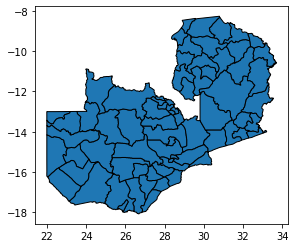

In [10]:
country_shp = geopandas.read_file(f'{taylor_data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
country_shp.plot(linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Crop yield

Zambian maize yield data reflects the predicted annual maize yield provided by farmers in the month of May, when the maize matures and changes colors prior to harvest, which allows the farmers to estimate what their yield will be in the following months. These predictions are in units of metric tons per hectare and provide valuable insight to the Zambian government as they plan for the quanitites of food to import into the country in the future. For more metadata, see the websites for the [Central Statistics Office of Zambia (CSO)](https://www.zamstats.gov.zm/) and the [Summary statistics from CSO.](https://www.zamstats.gov.zm/agriculture-environment-statistics/)

In order to standardize the names of all districts shared between the geoboundaries and the crop yield data, we correct for spelling, dashes, and apostrophes. 


In [11]:
crop_df = pd.read_csv(taylor_data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [12]:
list(set(crop_districts) - set(country_districts))

['Ikelenge', 'Mafinga']

In [13]:
list(set(country_districts) - set(crop_districts))

[]

In [14]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Crop land

In [15]:
weights = pd.read_feather(f"{taylor_data_dir}/weights/{weight_file_name}.feather")
# weights

<AxesSubplot:>

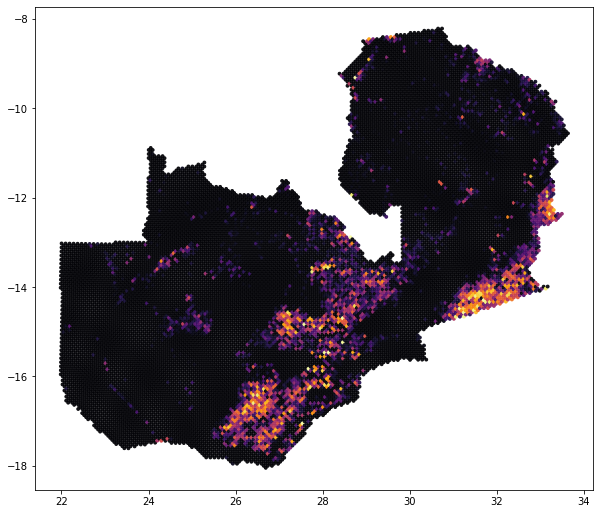

In [16]:
weights_gdf = geopandas.GeoDataFrame(
    weights, 
    geometry = geopandas.points_from_xy(x = weights.lon, y = weights.lat), 
    crs='EPSG:4326'
)
weights_gdf.plot(figsize = (10,10),
                 cmap = 'inferno',
                 markersize = marker_sz,
                 alpha = .9,
                 column = 'crop_perc')
# plt.axis('off')

In [17]:
weights.crop_perc = weights.crop_perc.fillna(0)
# #weights.crop_perc = weights.crop_perc + 0.0001

## Features

Append annual features files together into one file: `features_raw`.

In [18]:
features_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"{taylor_data_dir}/features/{satellite}/{feature_file_name}_{yr}.feather")
    
    if (yr == 2013) & (satellite == "landsat-8-c2-l2"):
        features_x = features_x[features_x.month > 9]
    elif (yr == 2015) & (satellite == "sentinel-2-l2a"):
        features_x = features_x[features_x.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2015.feather
feature.shape (9641, 1004)
Appending: 2015

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2016.feather
feature.shape (145645, 1004)
Appending: 2016

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2017.feather
feature.shape (262443, 1004)
Appending: 2017

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2018.feather
feature.shape (411433, 1004)
Appending: 2018

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2019.feather
feature.shape (565985, 1004)
Appending: 2019

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2020.feather
feature.shape (699975, 1004)
Appending: 2020

Opening: sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_2021.feather
feature.shape (841959, 1004)
Appending: 2021



In [19]:
features = features_raw.copy()

In [20]:
# carry months October, November, and December over to the following year's data
# these months represent the start of the growing season for the following year's maize yield
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

### Filter month range

In [21]:
# subset the features to only the month range selected at the top of the notebook
features = features[features.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon', 'lat', 'year', 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. This results in a Tidy data structure, with each row representing an image, and each column representing a feature for a certain month.

In [22]:
features = features.set_index(['lon','lat', "year", 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

### Replace "inf" values with `NaN`

Infinity values are the result of **(insert reason here)**. We replace them with `NaN` because **(insert reason here)**.

In [23]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
# features

### Attach crop weights
Attach weight to each point (% area cropped of surrounding 1 km^2).

In [24]:
features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features = features.drop(["geometry"], axis = 1)
# features

### Mask croppped regions

In [25]:
# any 1 km^2 cell with a crop percentage > 0 will be retained
# the mask will not be applied if crop_mask is set to False at the top of this notebook
if crop_mask:
    features = features[features.crop_perc > 0]
else:
    pass
# features

### Make "features" a `GeoDataFrame`

The coordinate reference system is set to EPSG 4326 - WGS 84, the latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System.

In [26]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Plot any single feature

In [27]:
# mn = 9
# yr = 2017
# feature = 999

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

### Drop 'lat' and 'lon' columns

In [28]:
# Drop the redundant independent lon and lat columns now that they are in a geometry column
features = features.drop(['lon', 'lat'], axis = 1)

### Join features to country geometry

In [29]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')
features

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,geometry,index_right
348,2016,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,3.946593,5.302142,5.075759,5.198160,5.814113,NaN,NaN,0.052945,POINT (22.05200 -15.00970),Kalabo
349,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,3.270982,3.856683,3.446999,3.961444,5.840712,NaN,NaN,0.052945,POINT (22.05200 -15.00970),Kalabo
350,2018,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,3.081625,2.996627,3.409674,3.650143,4.191209,NaN,NaN,0.052945,POINT (22.05200 -15.00970),Kalabo
351,2019,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.271072,4.642756,5.419099,5.152423,3.783599,5.128443,5.235233,0.052945,POINT (22.05200 -15.00970),Kalabo
352,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,3.982560,4.154380,4.707381,4.843441,5.832340,NaN,NaN,0.052945,POINT (22.05200 -15.00970),Kalabo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90435,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.812651,2.839970,3.716929,3.984487,4.295646,3.502681,6.264046,0.000595,POINT (33.54313 -10.47465),Isoka
90436,2018,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.949130,2.979337,3.343377,4.139130,3.720012,3.710962,NaN,0.000595,POINT (33.54313 -10.47465),Isoka
90437,2019,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.690188,2.930397,3.385749,3.638913,7.727231,3.880942,3.144201,0.000595,POINT (33.54313 -10.47465),Isoka
90438,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903,0.000595,POINT (33.54313 -10.47465),Isoka


In [30]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

### Correct column names and drop geometry

In [31]:
# Drop NA's from the district column (called index_right) then rename the column index_right to district
features = (
    features
    # drop NA values
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
# make a copy of the features
points = features.copy()
# save the geometries as an object to join them later to the rows
points = features[['geometry']]
# save the years as an object to join them later to the rows
year = features[['year']]
# drop geometry column for 20/21 features
features = features.drop(['geometry'], axis = 1)
features

,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,district
0,2016,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,4.199941,3.946593,5.302142,5.075759,5.198160,5.814113,NaN,NaN,0.052945,Kalabo
1,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,3.395471,3.270982,3.856683,3.446999,3.961444,5.840712,NaN,NaN,0.052945,Kalabo
2,2018,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.756262,3.081625,2.996627,3.409674,3.650143,4.191209,NaN,NaN,0.052945,Kalabo
3,2019,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.160787,4.271072,4.642756,5.419099,5.152423,3.783599,5.128443,5.235233,0.052945,Kalabo
4,2020,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,3.523840,3.982560,4.154380,4.707381,4.843441,5.832340,NaN,NaN,0.052945,Kalabo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27770,2017,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.675864,2.812651,2.839970,3.716929,3.984487,4.295646,3.502681,6.264046,0.000595,Isoka
27771,2018,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.829903,2.949130,2.979337,3.343377,4.139130,3.720012,3.710962,NaN,0.000595,Isoka
27772,2019,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.700805,2.690188,2.930397,3.385749,3.638913,7.727231,3.880942,3.144201,0.000595,Isoka
27773,2020,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,2.777765,NaN,3.058775,3.743001,4.127277,3.901562,4.095835,3.106903,0.000595,Isoka


<AxesSubplot:>

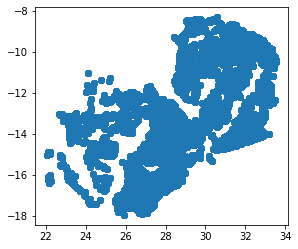

In [32]:
# visually check that the points object is what we expect it to look like
points.plot()

### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inoutated values with each step. First, the NA values are imputed at by both `year` and `district`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [33]:
# compute the number of cells in the features dataframe, based on the amount of rows (images), months, and feature columns
num_cells = len(features) * len(month_range) * num_features

In [34]:
# import dask.dataframe as dd

In [35]:
# dfeatures = dd.from_pandas(features, npartitions=1)

In [36]:
# %%time
# if impute_manual:
#     with Client(n_workers=16) as client:
        
#         print(f'Total rows: {(len(dfeatures))} \nPre-Impute NaN row count: {(len(dfeatures) - len(dfeatures.dropna()))} ',
#               f'\nPre-Impute NaN row %: {((len(dfeatures) - len(dfeatures.dropna())) / len(dfeatures))*100:.02f}',
#               f'\nPre-Impute NaN cell %: {(dfeatures.isna().sum().sum() / num_cells)*100:.02f}')

#         print(f'\nStep 1: Filling NaN values by month, year, and district group average')
#         dfeatures = (
#             dfeatures
#             .fillna(dfeatures
#                     .groupby(['year', 'district'], as_index=False)
#                     .transform('mean')
#                    )
#                 #.compute()
#         )
#         print(f'{(dfeatures.isna().sum().sum() / num_cells)*100:.02f} % NaN cell values after imputing step 1')

#         print(f'\nStep 2: Filling NaN values by month and district across group average')
#         dfeatures = (
#             dfeatures
#             .fillna(dfeatures
#                     .groupby(['district'], as_index=False)
#                     .transform('mean')
#                    )
# #                 .compute()
#         )
#         print(f'{(dfeatures.isna().sum().sum() / num_cells)*100:.02f} % NaN cell values after imputing step 2')

#         print('\nStep 3: Drop remaining NaN values')

#         print(f'Total rows: {(len(dfeatures))} \nPost-Impute NaN row count: ',
#               f'{(len(dfeatures) - len(dfeatures.dropna()))} \nPost-Impute NaN row %: ',
#               f'{((len(dfeatures) - len(dfeatures.dropna())) / len(dfeatures))*100:.02f}\n', sep = "")
#         dfeatures = dfeatures.dropna(axis=1)
#     #         .compute()
#         print(f'{(dfeatures.isna().sum().sum() / num_cells)*100:.02f} % NaN cell values\n')
# else:
#     dfeatures = dfeatures.set_index(['year', 'district'])
#     imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#     imputer.fit_transform(dfeatures)
#     dfeatures[:] = imputer.transform(dfeatures)
#     dfeatures = dfeatures.reset_index()

In [37]:
class bcolors:
    BL = '\x1b[1;34m' #GREEN
    GR = '\x1b[1;36m' #GREEN
    YL = '\x1b[1;33m' #YELLOW
    RD = '\x1b[1;31m' #RED
    RESET = '\033[0m' #RESET COLOR

In [38]:
%%time
if impute_manual:
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Starting total row count: {bcolors.BL}{ln_ft}{bcolors.RESET}',
          f'\nPre-Impute NaN row count: {bcolors.RD}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPre-Impute NaN row %: {bcolors.RD}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPre-Impute NaN cell %: {bcolors.RD}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 1: Filling NaN values by month, year, and district group average')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 1 NaN row count: {bcolors.YL}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 1 NaN row %: {bcolors.YL}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 1 NaN cell %: {bcolors.YL}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 2: Filling NaN values by month and district across group average')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features)
    ln_na = len(features.dropna())
    print(f'Post step 2 NaN row count: {bcolors.GR}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 2 NaN row %: {bcolors.GR}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 2 NaN cell %: {bcolors.GR}{(features.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 3: Drop remaining NaN values\n')
    features = features.dropna(axis=0)
    print(f'Ending total row count: {bcolors.BL}{len(features)}{bcolors.RESET}')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

CPU times: user 12.3 s, sys: 4.29 s, total: 16.6 s
Wall time: 16.6 s


### Save copy of completed data 

In [83]:
# duplicated features df so we can summarize features to district resolution for one set and still retain features at point resolution in other df
features_copy = features.copy()
# assign the geometry col to features_copy, but do not add this col to features df because we do not need geometry now that we have districts since it is summarized to district level
features_copy['geometry'] = points.geometry
# moving forward, use the plain features to summarize to district level (because we dont need geoometries for that since district is already present)

### Split features into 2014-2018 and 2014-2021

All feature data required the processing steps execute above. However, the following code is not executed on all features. The 2014-2018 (Landsat) or 2015-2018 (Sentinel) set of features will be summarized to administrative boundary level (all rows (points) have already been assigned to the district in which they reside). These summarized features and their districts will then be joined with the dsitrict-resolution crop data, split into train and test sets, and then used to train the model using ridge regression. We will then apply the trained model to the large, comprehensive feature set for 2014-2021 (Landsat) or 2015-2021 (Sentinel), which includes all years regardless if those years have ground truth crop data. We are most interested in the predictions for 2019-2021 because the model was not trained on these years. Therefore, we split the data here to execute different analysis moving forward. The code splits the data correctly no matter which satellite was selected at the top of the notebook.

In [84]:
# separate the data into 2 groups: 2014/2015-2018 for model training and 2014/2015-2021 for predicting on all years
features_model = features[features.year <= 2018]

# check that subsetting years worked
features_model["year"].unique()
# should be 2016, 2017, 2018 for Sentinel
# should be 2013, 2014, 2015, 2016, 2017, 2018 for Landsat

array([2016, 2017, 2018])

In [85]:
features_predictions = features[features.year >= 2019]

# check that subsetting years worked
features_predictions["year"].unique()
# should be 2019, 2020, 2021 regardless if the satellite is Sentinel or Landsat

array([2019, 2020, 2021])

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [86]:
features_model.columns

Index(['year', 'district', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7',
       '0_8',
       ...
       '999_4', '999_5', '999_6', '999_7', '999_8', '999_9', '999_10',
       '999_11', '999_12', 'crop_perc'],
      dtype='object', length=12003)

In [87]:
# create object that contains only feature columns, rather than all columns that would include district, year, etc.
# python index starts at 0, so here we specify to retain columns starting at 3 through every column besides the last
# the columns we omit stay in the dataframe, but are not included in the calculation in the next chunk
var_cols = features_model.columns[2:-1].values.tolist()
# call the object var_cols but not in list format so it is more readable:
features_model.columns[2:-1]
# these are all the feature columns that will be fed into the weighted_avg calculation 

Index(['0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10',
       ...
       '999_3', '999_4', '999_5', '999_6', '999_7', '999_8', '999_9', '999_10',
       '999_11', '999_12'],
      dtype='object', length=12000)

In [88]:
%%time
if weighted_avg:
    features_summary = (
        features_model
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
else:
    features_summary = features_model.groupby(['district',"year"], as_index = False).mean()
# features_summary

CPU times: user 1.38 s, sys: 392 ms, total: 1.77 s
Wall time: 1.76 s


In [89]:
features_summary

,district,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc
0,Chadiza,2016,1.774352e-08,2.589167e-07,1.436250e-08,9.018168e-07,8.394103e-07,0.000000e+00,0.000000e+00,1.658468e-06,...,2.389959,3.606578,3.897708,3.984689,4.382867,4.413708,4.150110,4.179796,3.654984,0.372614
1,Chadiza,2017,7.629715e-07,2.589167e-07,6.319501e-07,7.484689e-07,3.599211e-07,0.000000e+00,0.000000e+00,1.678389e-06,...,3.383917,3.143583,3.455484,3.623478,4.177531,4.076463,4.428639,4.639797,3.243259,0.372614
2,Chadiza,2018,0.000000e+00,0.000000e+00,6.319501e-07,1.484147e-07,1.794746e-07,0.000000e+00,0.000000e+00,0.000000e+00,...,2.795487,3.093033,3.278398,3.647738,4.116855,4.368205,4.027768,4.376283,3.654984,0.372614
3,Chama,2016,7.807150e-07,2.589167e-07,2.848226e-07,9.227893e-07,4.897490e-08,0.000000e+00,0.000000e+00,3.038715e-08,...,2.385796,3.016974,3.501716,3.678528,3.644735,3.944598,4.150110,4.179796,3.907813,0.152064
4,Chama,2017,7.807150e-07,2.589167e-07,6.319501e-07,4.418991e-07,2.326308e-07,0.000000e+00,0.000000e+00,0.000000e+00,...,2.722624,2.999080,3.272772,3.574016,3.758753,3.960154,4.146494,4.103087,3.290153,0.152064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Solwezi,2017,7.807150e-07,2.589167e-07,6.263577e-07,3.259642e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.721626,2.704519,2.982082,3.063216,3.097713,3.165617,3.324386,3.549216,3.644000,0.045238
212,Solwezi,2018,5.319917e-07,1.695561e-07,4.138434e-07,0.000000e+00,4.072126e-07,6.009613e-07,0.000000e+00,2.140101e-07,...,2.413896,2.740798,2.986456,3.055047,3.160299,3.130693,3.117124,3.425223,3.654984,0.045238
213,Zambezi,2016,2.810574e-07,2.174901e-07,6.319501e-07,2.768368e-07,1.043165e-07,9.197365e-08,5.624696e-08,0.000000e+00,...,2.518284,2.664772,3.116508,3.377726,3.576907,3.719119,4.150110,4.175346,3.654984,0.062391
214,Zambezi,2017,7.807150e-07,2.589167e-07,3.412531e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.628586,2.677305,2.867396,3.017750,3.236804,3.462403,3.773463,4.015549,3.322997,0.062391


### Join crop data

In [90]:
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# crop_df_x

In [91]:
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_df_x.set_index(["district", "year"]))
    .reset_index())
features_summary
# now that the data is joined, the column yield_mt is present in features_summary

,district,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,yield_mt
0,Chadiza,2016,1.774352e-08,2.589167e-07,1.436250e-08,9.018168e-07,8.394103e-07,0.000000e+00,0.000000e+00,1.658468e-06,...,3.606578,3.897708,3.984689,4.382867,4.413708,4.150110,4.179796,3.654984,0.372614,1.876427
1,Chadiza,2017,7.629715e-07,2.589167e-07,6.319501e-07,7.484689e-07,3.599211e-07,0.000000e+00,0.000000e+00,1.678389e-06,...,3.143583,3.455484,3.623478,4.177531,4.076463,4.428639,4.639797,3.243259,0.372614,2.882947
2,Chadiza,2018,0.000000e+00,0.000000e+00,6.319501e-07,1.484147e-07,1.794746e-07,0.000000e+00,0.000000e+00,0.000000e+00,...,3.093033,3.278398,3.647738,4.116855,4.368205,4.027768,4.376283,3.654984,0.372614,1.299279
3,Chama,2016,7.807150e-07,2.589167e-07,2.848226e-07,9.227893e-07,4.897490e-08,0.000000e+00,0.000000e+00,3.038715e-08,...,3.016974,3.501716,3.678528,3.644735,3.944598,4.150110,4.179796,3.907813,0.152064,1.257456
4,Chama,2017,7.807150e-07,2.589167e-07,6.319501e-07,4.418991e-07,2.326308e-07,0.000000e+00,0.000000e+00,0.000000e+00,...,2.999080,3.272772,3.574016,3.758753,3.960154,4.146494,4.103087,3.290153,0.152064,2.308008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Solwezi,2017,7.807150e-07,2.589167e-07,6.263577e-07,3.259642e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.704519,2.982082,3.063216,3.097713,3.165617,3.324386,3.549216,3.644000,0.045238,1.196322
212,Solwezi,2018,5.319917e-07,1.695561e-07,4.138434e-07,0.000000e+00,4.072126e-07,6.009613e-07,0.000000e+00,2.140101e-07,...,2.740798,2.986456,3.055047,3.160299,3.130693,3.117124,3.425223,3.654984,0.045238,1.831869
213,Zambezi,2016,2.810574e-07,2.174901e-07,6.319501e-07,2.768368e-07,1.043165e-07,9.197365e-08,5.624696e-08,0.000000e+00,...,2.664772,3.116508,3.377726,3.576907,3.719119,4.150110,4.175346,3.654984,0.062391,1.725293
214,Zambezi,2017,7.807150e-07,2.589167e-07,3.412531e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.677305,2.867396,3.017750,3.236804,3.462403,3.773463,4.015549,3.322997,0.062391,1.490456


In [92]:
features_summary

,district,year,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12,crop_perc,yield_mt
0,Chadiza,2016,1.774352e-08,2.589167e-07,1.436250e-08,9.018168e-07,8.394103e-07,0.000000e+00,0.000000e+00,1.658468e-06,...,3.606578,3.897708,3.984689,4.382867,4.413708,4.150110,4.179796,3.654984,0.372614,1.876427
1,Chadiza,2017,7.629715e-07,2.589167e-07,6.319501e-07,7.484689e-07,3.599211e-07,0.000000e+00,0.000000e+00,1.678389e-06,...,3.143583,3.455484,3.623478,4.177531,4.076463,4.428639,4.639797,3.243259,0.372614,2.882947
2,Chadiza,2018,0.000000e+00,0.000000e+00,6.319501e-07,1.484147e-07,1.794746e-07,0.000000e+00,0.000000e+00,0.000000e+00,...,3.093033,3.278398,3.647738,4.116855,4.368205,4.027768,4.376283,3.654984,0.372614,1.299279
3,Chama,2016,7.807150e-07,2.589167e-07,2.848226e-07,9.227893e-07,4.897490e-08,0.000000e+00,0.000000e+00,3.038715e-08,...,3.016974,3.501716,3.678528,3.644735,3.944598,4.150110,4.179796,3.907813,0.152064,1.257456
4,Chama,2017,7.807150e-07,2.589167e-07,6.319501e-07,4.418991e-07,2.326308e-07,0.000000e+00,0.000000e+00,0.000000e+00,...,2.999080,3.272772,3.574016,3.758753,3.960154,4.146494,4.103087,3.290153,0.152064,2.308008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Solwezi,2017,7.807150e-07,2.589167e-07,6.263577e-07,3.259642e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.704519,2.982082,3.063216,3.097713,3.165617,3.324386,3.549216,3.644000,0.045238,1.196322
212,Solwezi,2018,5.319917e-07,1.695561e-07,4.138434e-07,0.000000e+00,4.072126e-07,6.009613e-07,0.000000e+00,2.140101e-07,...,2.740798,2.986456,3.055047,3.160299,3.130693,3.117124,3.425223,3.654984,0.045238,1.831869
213,Zambezi,2016,2.810574e-07,2.174901e-07,6.319501e-07,2.768368e-07,1.043165e-07,9.197365e-08,5.624696e-08,0.000000e+00,...,2.664772,3.116508,3.377726,3.576907,3.719119,4.150110,4.175346,3.654984,0.062391,1.725293
214,Zambezi,2017,7.807150e-07,2.589167e-07,3.412531e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.677305,2.867396,3.017750,3.236804,3.462403,3.773463,4.015549,3.322997,0.062391,1.490456


## Model

In [93]:
# create a new object that 
#model_year = features_summary[features_summary.year.isin([
#   2014,
#   2015,
#   2016,
#   2017,
#   2018,
#])]

### Define `x's` and `y's`

In [94]:
if weighted_avg:
    drop_cols = ['district', 'year', 'yield_mt']
else:
    drop_cols = ['district', 'year', 'yield_mt', "crop_perc"]

In [95]:
x_all = features_summary.drop(drop_cols, axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

### Split into train and test sets

In [96]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [97]:
print("Total N: ", len(x_all), "\n", 
      "Train N: ", len(x_train), "\n",
      "Test  N: ", len(x_test), sep = "")

Total N: 216
Train N: 172
Test  N: 44


### Train model

In [98]:
# sorted(sklearn.metrics.SCORERS.keys())

In [99]:
# cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
# ridge_cv_random = RidgeCV(cv=cv, alphas=[0.001, 0.01, 1, 10])
# ridge_cv_random = RidgeCV(cv=cv, alphas=np.logspace(-8, 8, base=10, num=17))
# ridge_cv_random = RidgeCV(
#     cv=5, 
#     alphas=np.logspace(-5, 5, base=10, num=11),
#     scoring='r2',
#     scoring='max_error',
#     scoring='explained_variance'
# )
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [100]:
print(f"Estimated regularization parameter {ridge_cv_random.alpha_}")

Estimated regularization parameter 1.0


### Validation set $R^2$ performance

In [101]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.55


### Train set

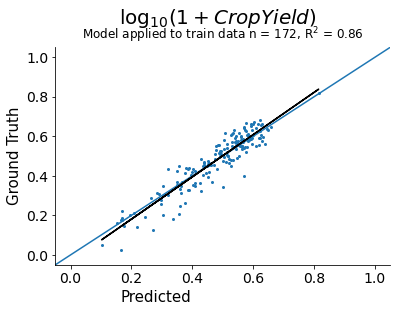

In [102]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

fig, ax = plt.subplots(ncols=1)
# fig, ax = plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [1, 1])
m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()
# the model is plotted with a black trendline and a blue 45 degree line for reference of what a perfect correlation would look like

In [103]:
print(f"Training R^2 = {r2_score(y_train, y_pred):0.2f}\nPearsons r = {pearsonr(y_pred, y_train)[0]:0.2f}") 

Training R^2 = 0.86
Pearsons r = 0.93


In [104]:
pearsonr(y_pred, y_train)[0]  ** 2

0.8656328885225552

In [105]:
ridge_cv_random.score(x_train, y_train)

0.8620653628575978

### Test set

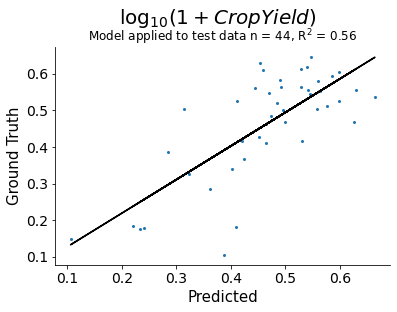

In [106]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [107]:
print(f"Testing set R^2 = {r2_score(y_test, y_pred):0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Testing set R^2 = 0.56
Testing set pearsons R = 0.75


### Plot the fitted features

## add to this markdown chunk to explian what is happening in this section

In [108]:
# remind yourself that the geometry column is present in this version of the features df
features_copy.columns

Index(['year', 'district', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7',
       '0_8',
       ...
       '999_5', '999_6', '999_7', '999_8', '999_9', '999_10', '999_11',
       '999_12', 'crop_perc', 'geometry'],
      dtype='object', length=12004)

In [109]:
pred_features = features_copy.copy()

In [110]:
x_all = pred_features.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [111]:
pred_features = geopandas.GeoDataFrame(pred_features)

In [112]:
pred_features['fit'].mask(pred_features['crop_perc']==0, 0, inplace=True)
# pred_features.loc[pred_features["crop_perc"] == 0, "fit"] = 0   ### Does same thing but differently

In [113]:
# pred_features = pred_features[pred_features.crop_perc > 0].reset_index(drop = True)

In [114]:
pred_features['fit'].mask(pred_features['fit'] > 2, 0, inplace=True)

In [115]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

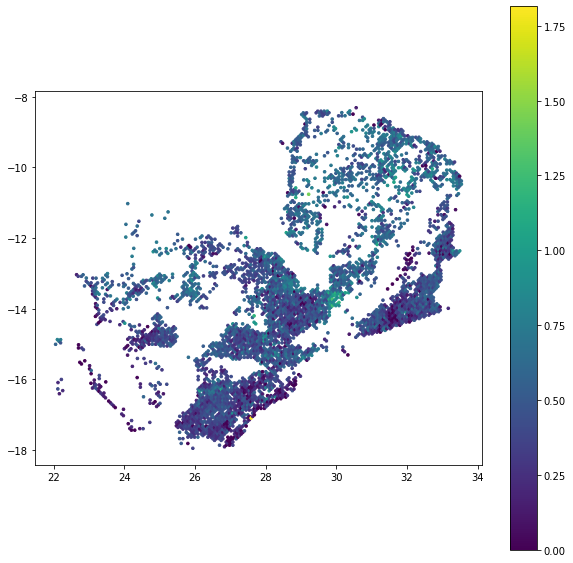

In [116]:
plot_features.plot(figsize = (10,10),
                   marker='H',
                   legend = True,
                   markersize = marker_sz,
#                    alpha = .9,
                   column = 'fit')

### Run trained model on features for 2014 - 2021

In [117]:
# remind yourself of the columns in this df
features_predictions.columns

Index(['year', 'district', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7',
       '0_8',
       ...
       '999_4', '999_5', '999_6', '999_7', '999_8', '999_9', '999_10',
       '999_11', '999_12', 'crop_perc'],
      dtype='object', length=12003)

In [118]:
year

,year
0,2016
1,2017
2,2018
3,2019
4,2020
...,...
27770,2017
27771,2018
27772,2019
27773,2020


In [119]:
features_predictions.shape

(13909, 12003)

In [120]:
# because our original object years that we created earlier is not the same number of rows as our processed features_predictions df, we need to recreate the years object to assign it to the df later
years = features_predictions[["year"]]

In [121]:
years

,year
3,2019
4,2020
5,2021
9,2019
10,2020
...,...
27767,2020
27768,2021
27772,2019
27773,2020


In [122]:
features_predictions = features_predictions.drop([
    'district', 
    'year', 
    "crop_perc"
], axis = 1)

In [123]:
# need to execute the ridge_cv_random within the np.maximum() function because some predictions results are negative and we need them all to be positive because conceptually crop yields cannot be negative
pred_14_21 = np.maximum(ridge_cv_random.predict(features_predictions), 0)
pred_14_21

array([0.        , 0.35400365, 0.32626911, ..., 0.87168052, 0.64361092,
       0.58244068])

In [124]:
# check that the length of the array of predicitions is the same number of rows as the feature data fed into the model
length_preds = len(pred_14_21)
length_features = len(features_predictions)
length_preds == length_features

True

In [125]:
# convert the predictions from an array into a gdf so we can re-join the points and year variables to plot 
pred_14_21_gdf = geopandas.GeoDataFrame(pred_14_21)
# rename column for predictions just for clarity, this duplicates the column 0 so we need to drop in the next step
pred_14_21_gdf['pred_yields'] = pred_14_21_gdf[0]
pred_14_21_gdf

,0,pred_yields
0,0.000000,0.000000
1,0.354004,0.354004
2,0.326269,0.326269
3,0.305742,0.305742
4,0.657885,0.657885
...,...,...
13904,0.534448,0.534448
13905,0.545126,0.545126
13906,0.871681,0.871681
13907,0.643611,0.643611


In [126]:
# drop one duplicated column, the one with the non-descriptive name
pred_14_21_gdf = pred_14_21_gdf.drop([0], axis = 1)

pred_14_21_gdf

,pred_yields
0,0.000000
1,0.354004
2,0.326269
3,0.305742
4,0.657885
...,...
13904,0.534448
13905,0.545126
13906,0.871681
13907,0.643611


In [131]:
# first make a copy of the gdf but we will move forward with processing the original file
pred_14_21_gdf_copy = pred_14_21_gdf.copy()
# rejoin the points geometry and year columns so we can plot both years independently
pred_14_21_gdf['geometry'] = points.geometry
pred_14_21_gdf['year'] = year
# check that the geometries were properly rejoined
pred_14_21_gdf

,pred_yields,geometry,year
0,0.000000,POINT (22.05200 -15.00970),2016
1,0.354004,POINT (22.05200 -15.00970),2017
2,0.326269,POINT (22.05200 -15.00970),2018
3,0.305742,POINT (22.05200 -15.00970),2019
4,0.657885,POINT (22.05200 -15.00970),2020
...,...,...,...
13904,0.534448,POINT (28.61195 -16.00696),2020
13905,0.545126,POINT (28.61195 -16.00696),2021
13906,0.871681,POINT (28.61340 -16.18770),2016
13907,0.643611,POINT (28.61340 -16.18770),2017


In [128]:
# separate the data by year, we care most about 2019, 2020, and 2021 so these are the default years to subset the predictions df

#yr = 2014
#yr = 2015
#yr = 2016
#yr = 2017
yr = 2018
#yr = 2019
#yr = 2020
#yr = 2021

pred_yield = pred_14_21_gdf[pred_14_21_gdf.year == yr]

In [129]:
pred_yield

,pred_yields,geometry,year
2,0.326269,POINT (22.05200 -15.00970),2018
8,0.225273,POINT (22.10141 -14.87558),2018
14,0.499755,POINT (22.11478 -16.27280),2018
20,0.358359,POINT (22.11922 -16.09266),2018
26,0.102850,POINT (22.14671 -14.92161),2018
...,...,...,...
13884,0.448276,POINT (28.60649 -15.28389),2018
13890,0.412026,POINT (28.60718 -15.37427),2018
13896,0.729099,POINT (28.60858 -15.55501),2018
13902,0.808865,POINT (28.61195 -16.00696),2018


<AxesSubplot:>

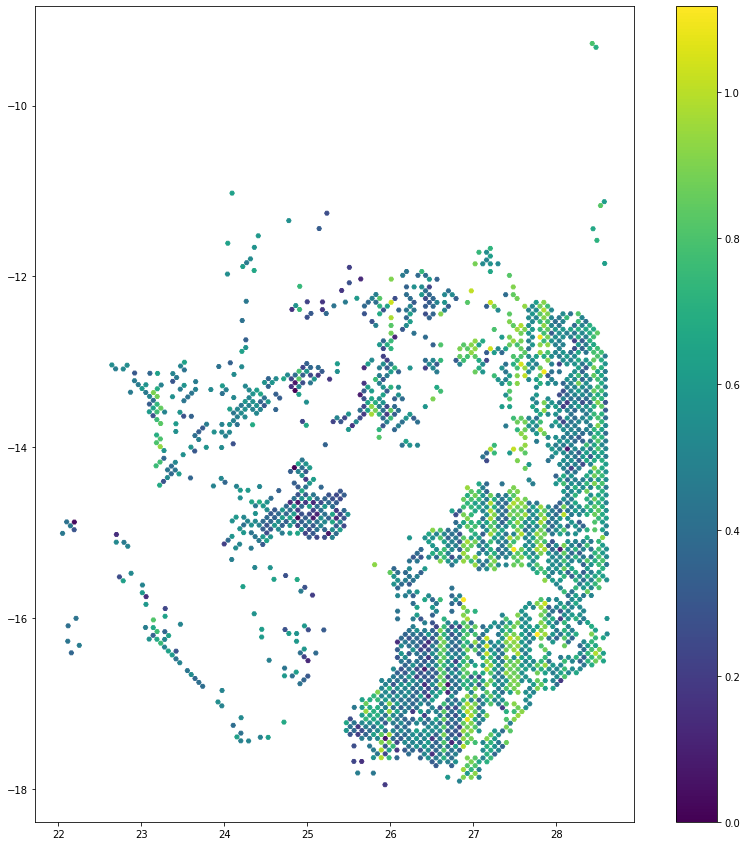

In [85]:
# plot 2019 crop predictions
pred_yield.plot(figsize= (15,15),
                  marker = 'H',
                  legend = True,
                  markersize = 20,
                  column = "pred_yields")

## Yield and Residual Plots
### Create data frame 

In [ ]:
x_all = features_summary.drop(drop_cols, axis = 1)

residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
#demean by location
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)
# residual_gdf

### Crop yield histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

### Log transform crop yield histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### Crop prediction histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

### Residual histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [ ]:
residual_gdf.residual.min()

In [ ]:
residual_gdf.residual.max()

### Log rop yield vs residuals

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### District residuals

In [ ]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

### Difference from the Mean

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

In [ ]:
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

In [ ]:
for yr in range(year_start+1, year_end+1):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's r: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's r: {pearson_r[0]:.2f}", sep = "")

In [ ]:
round(pearson_r[0] ** 2, 2)